## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('/home/aleksandr/Документы/GitHub/data/Tourism/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

print('Первая дата ислледования в каждой группе:\n', data.groupby('group')['date'].agg('min'))
print('\nПоследняя дата ислледования в каждой группе:\n', data.groupby('group')['date'].agg('max'))

Первая дата ислледования в каждой группе:
 group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

Последняя дата ислледования в каждой группе:
 group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# Создание таблицы с агрегатными функциями
ab_data = data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

display(ab_data)
print('Сумма, затраченная на путевки по каждой группе в млн. руб:\n', data.groupby('group')['price'].agg('sum') / 10e6)

,group,count_visits,count_purchases,sum_price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


Сумма, затраченная на путевки по каждой группе в млн. руб:
 group
A    143.626
B    155.410
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
#Создание множеств для определения пользователей участвовавших в двух тестовых группах
set_a = set(data[data['group']=='A']['user_id'])
set_b = set(data[data['group']=='B']['user_id'])
user_intersection = set_a.intersection(set_b)

print('Количество пользователей, которые попали в обе тестовые группы:', len(user_intersection))

Количество пользователей, которые попали в обе тестовые группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

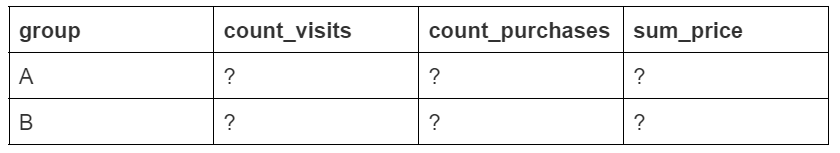
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
grouped_data = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

print('Количество посещений сайта в группе А:', grouped_data['count_visits'][0], 'и в группе В:', grouped_data['count_visits'][1])

Количество посещений сайта в группе А: 145307 и в группе В: 145381


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Выводы: В группе А при меньшей посещаемости, больше количество заказов чем в группе В. В тоже время общая сумма в группе А меньше чем в В. Группы сбалансированы: совпадают временные интервалы, отсутствуют пересечения в группах. При этом разница между показателями 'count_visits' и 'count_purchases' в группах менее 2%, а по показателю 'sum_price' - 8%.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
#Добавление к таблице столбцов конверсии и среднего чека
grouped_data['conversion'] = grouped_data['count_purchases']/grouped_data['count_visits']*100
grouped_data['mean_check'] = grouped_data['sum_price']/grouped_data['count_purchases']

#Вывод результата
print('Конверсия в группе А:', round(grouped_data['conversion'].loc[0], 2), '%')
print('Конверсия в группе В:', round(grouped_data['conversion'].loc[1], 2), '%')
print('Средний чек в группе А:', round(grouped_data['mean_check'].loc[0]), 'рублей')
print('Средний чек в группе В:', round(grouped_data['mean_check'].loc[1]), 'рублей')

Конверсия в группе А: 12.03 %
Конверсия в группе В: 11.89 %
Средний чек в группе А: 81076 рублей
Средний чек в группе В: 88665 рублей


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вариант А эфективнее по показателю конверсии, но при этом уступает варианту В в среднем чеке.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot_data = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

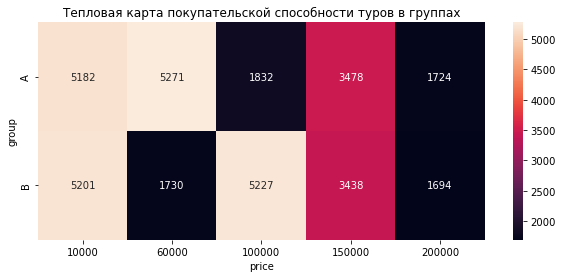

In [10]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot_data, fmt='.0f', annot=True);
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Наибольшей покупательской способностью в группе А по сравнению с группой В обладают туры со стоимостью 60_000. Наименьшей - 100_000.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [11]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits']*100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']

print('Конверсия 3 января 2021 года:')
display(daily_data[daily_data['date'] == '2021-01-03'][['group', 'conversion']].round(2))
 
print('Средний чек 3 января 2021 года:')
display(daily_data[daily_data['date'] == '2021-01-03'][['group', 'mean_check']].round())

Конверсия 3 января 2021 года:


,group,conversion
2,A,11.34
3,B,11.39


Средний чек 3 января 2021 года:


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [12]:
# Кумулятивное количество посещений страницы
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
# Кумулятивное количество покупок
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
# Кумулятивная сумма покупок
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
# Кумулятивная конверсия
daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits'] * 100
# Кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

print('Кумулятивная конверсия в группе В на 20 января:', round(daily_data[daily_data['date'] == '2021-01-20']['cum_conversion'].iloc[1], 2))
print('Кумулятивный средний чек в группе А на 12 января 2021:', round(daily_data[daily_data['date'] == '2021-01-12']['cum_mean_check'].iloc[0]))

Кумулятивная конверсия в группе В на 20 января: 11.9
Кумулятивный средний чек в группе А на 12 января 2021: 81492


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

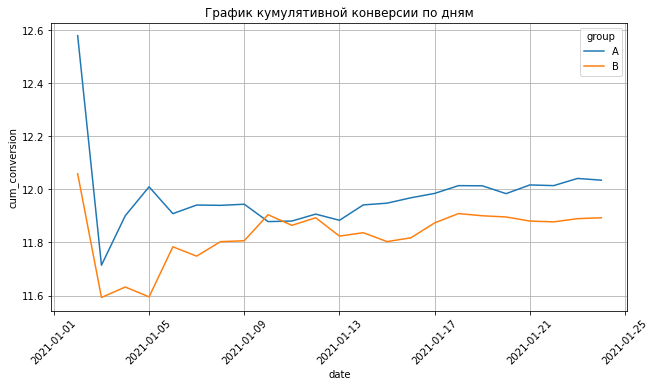

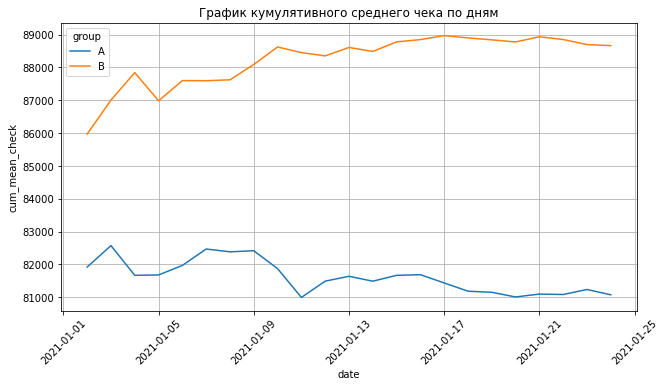

In [13]:
# строим lineplot для кумулятивной конверсии во времени в каждой группе
cum_conversion_fig = plt.figure(figsize=(8, 4))
ax = cum_conversion_fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

# строим lineplot для кумулятивной конверсии во времени в каждой группе
mean_check_fig = plt.figure(figsize=(8, 4))
ax = mean_check_fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

До 2021-01-09 наблюдаются скачкообразные и не стабильные изменения в графиках кумулятивных конверсии и среднего чека, но после 2021-01-11 резкие скачки прекратились (кривая графика переходит в прямую). По графику кумулятивной конверсии видно, что конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. В тоже время кумулятивный средний чек в группе В выше чем в группе А. На основании стабилизированных кумулятивных графиков мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [13]:
# Применим z-тест для пропорций на примере конверсии в группах. 
# Нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_data['count_purchases'], #число "успехов"
    nobs=grouped_data['count_visits'], #общее число наблюдений
    alternative='larger'
)
# Выводим результат на экран
print('p-value: ', round(p_value, 2))
# Сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Разницы между вариантами посадочной страницы официального сайта компании нет — они одинаково эффективны по метрике конверсии

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [14]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval)) 

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Можно отчётливо заметить пересечение интервалов. Cуществует вероятность, что истинное значение конверсии в обеих группах может совпасть.
Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии может быть как положительной, так и отрицательной. Это значит, что варианты А и B равнозначны по метрике конверсии. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [15]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [16]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group'] == 'A']['mean_check'],
    b=daily_data[daily_data['group'] == 'B']['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Согласно Т-теста ежедневный средний чек в группе А меньше чем в группе В

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [31]:
# Доверительный интервал для группы А
n = daily_data[daily_data['group'] == 'A']['count_visits'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = daily_data[daily_data['group'] == 'A']['mean_check'].mean()  # выборочное среднее
x_std = daily_data[daily_data['group'] == 'A']['mean_check'].std()  # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval_a = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал среднего чека для группы А: {}'.format(confidence_interval_a)) # выводим результат

Доверительный интервал среднего чека для группы А: (79630, 82308)


In [33]:
# Доверительный интервал для группы В
n = daily_data[daily_data['group'] == 'B']['count_visits'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = daily_data[daily_data['group'] == 'B']['mean_check'].mean()  # выборочное среднее
x_std = daily_data[daily_data['group'] == 'B']['mean_check'].std()  # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval_b = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал среднего чека для группы В: {}'.format(confidence_interval_b)) # выводим результат

Доверительный интервал среднего чека для группы В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Между интервалами отсуствуют пересечения. Но пределы доверительного интервала группы В выше чем группы А. А также разница метрик доверительного интервала В ниже чем в группе А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В комплексе по метрикам конверсии и среднему чеку эффективнее вариант В.
1) Не смотря на то, что по графику кумулятивной конверсии конверсия группы В ниже чем группы А, согласно проверки статистической значимости конверсии по z-тесту — варианты одинаково эффективны по метрике конверсии.
2) Средний чек группы В выше группы А согласно кумулятивного графика и построенного доверительного интервала.